
# Perform Customer Clustering for CG based on user portrait and corresponding transactions


In [2]:
# -*- coding: utf-8 -*-
import sys, getopt
import pandas as pd
import datetime
import os
import Tkinter, tkFileDialog
import numpy as np

In [3]:
NOW = pd.to_datetime(datetime.date.today())
inputfile = '/Users/ito/venv/pyspark-rec/data/VijayData.csv'

### Load the data

In [4]:
orders = pd.read_csv(inputfile, sep=',', engine='c', parse_dates=['TimeStamp'])
print orders.shape
orders.head()

(51243, 3)


,UserID,Spent,TimeStamp
0,760,25.0,2009-06-11
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-09-07
4,1940,70.0,2013-01-25


* create RFM tables

In [5]:
frequency = orders.groupby('UserID').Spent.agg({'frequency': lambda x: len(x)})
recency = orders.groupby('UserID').TimeStamp.agg({'recency': lambda x: (NOW - x.max()).days})
monetary_value = orders.groupby('UserID').Spent.agg({'monetary_value': lambda x: x.mean()})

/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
portrait_df = pd.concat([frequency, recency, monetary_value],join="inner",axis=1)
portrait_df.head(5)

,frequency,recency,monetary_value
UserID,,,
10,1.0,4603,30.000000
80,7.0,1147,71.428571
90,10.0,1798,115.800000
120,1.0,2263,20.000000
130,2.0,3774,50.000000


## Customer Clustering based on RFM values (can be adapted with other features)

### Data Normalization before training process
Since the distance in sklearn's k-means is euclidean, while we should perform a similarity based clustering (e.g., cosine, PCC, etc.), hence the normalization will make the score of euclidean equalize to cosine -- so to perform similarity based clustering.

In [56]:
from sklearn.preprocessing import normalize

X_ori = np.array(portrait_df)
normed_X = normalize(X_ori, axis=0, norm='l1')
X = normed_X
# pd.DataFrame(X)[[0]].sum()

In [8]:
# XX = np.array(portrait_df)
# XX = normalize(XX, axis=0, norm='l2')
# pd.DataFrame(XX)[[0]].sum()

### Plot of an elbow method for #cluster selection. 

Firstly, initialize the plot env.

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.plot()
# colors = ['b', 'g', 'r']
# markers = ['o', 'v', 's']

Perform k-means while tracking their avg clustering distortions.

The “elkan” variation is more efficient by using the triangle inequality.
And it doesn’t support sparse data -- which is good -- our data is dense :)

In [10]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, algorithm='elkan',init='k-means++').fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X.shape[0])

Plot the elbow according to the distortions from k-means.

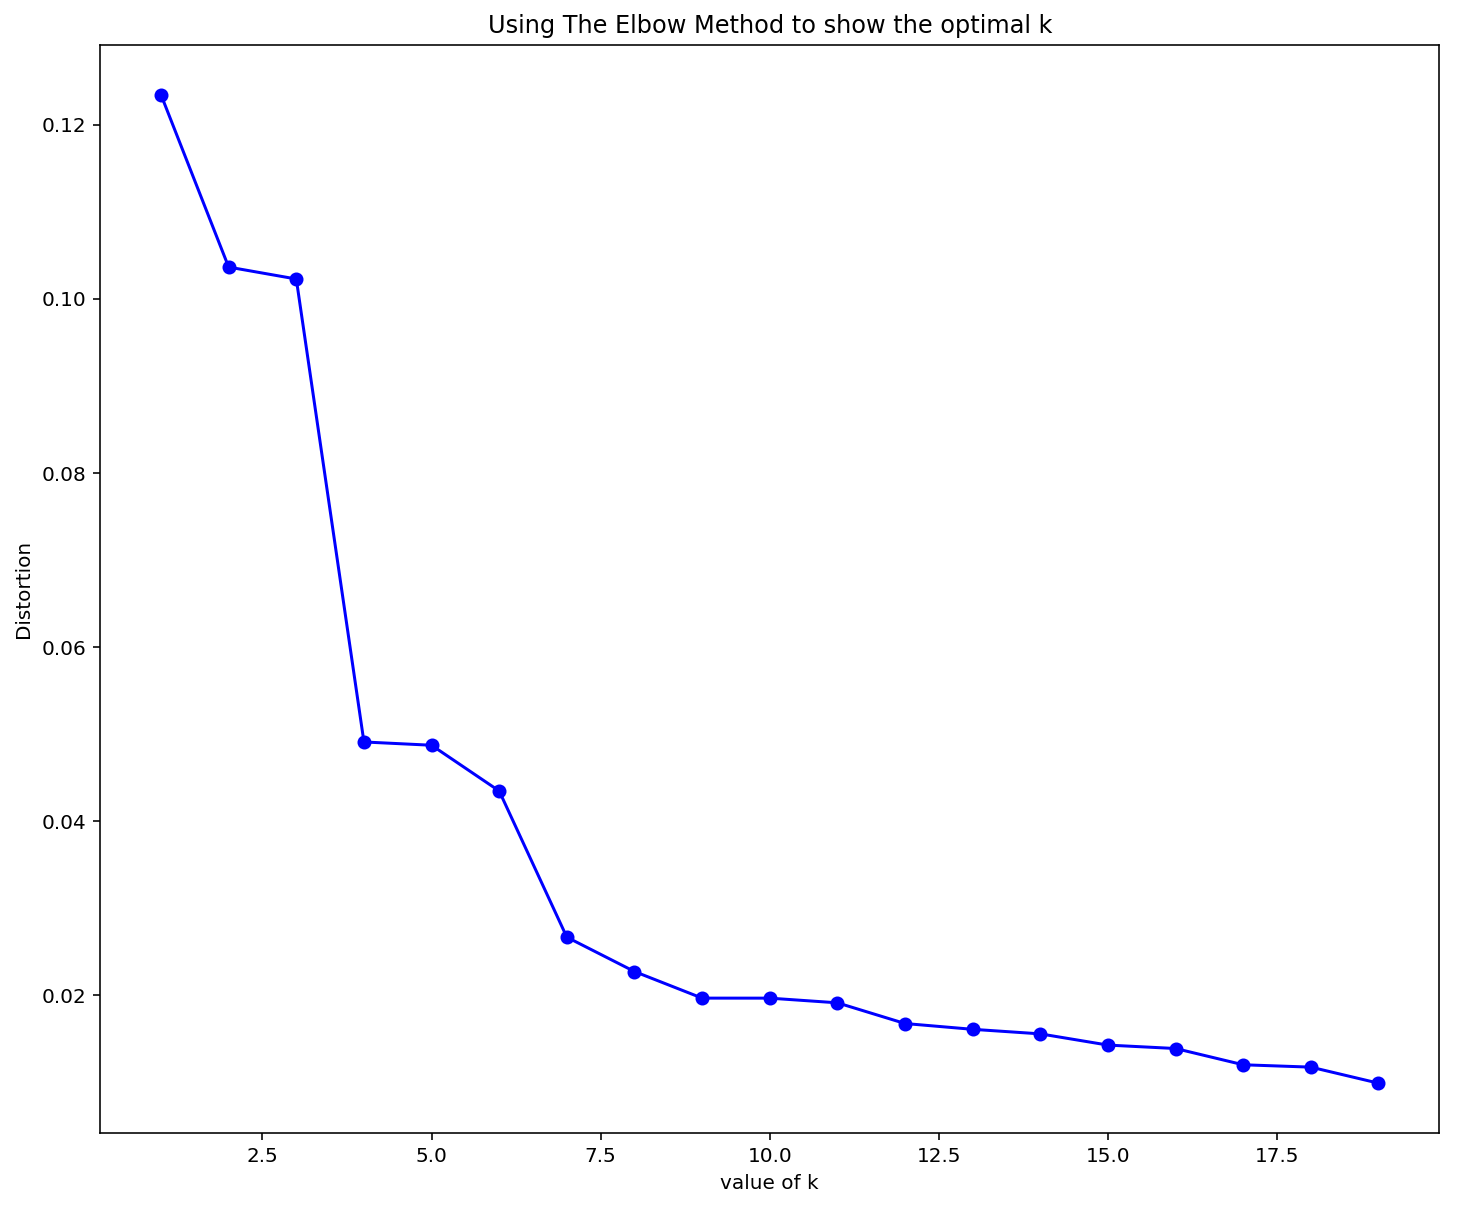

In [11]:
plt.plot(K, distortions, 'bo-')
plt.xlabel('value of k')
plt.ylabel('Distortion')
plt.title('Using The Elbow Method to show the optimal k')
plt.gcf().set_size_inches(12, 10)
plt.show()

At this stage, I would rather choose k = 5 for k, since 5, 6, 7.. share similar performance. 

Hence let's proceed to analyse when k = [7,9]. 
Currently, we consider the case when k = 8.

In [12]:
# from sklearn.cluster import AffinityPropagation
# APModel = AffinityPropagation().fit(X)

## Clusters Analysis

### K-means

In [13]:
K=8
kmeanModelfinal = KMeans(n_clusters=K, algorithm='elkan').fit(X)

See the number of customers in each cluster.

In [14]:
from collections import Counter
clusters = kmeanModelfinal.labels_.tolist()
clusters_dic = Counter(clusters)
pie_vec = [clusters_dic[i] for i in range(K)]
print pie_vec

[8115, 40, 186, 2355, 13, 85, 1655, 5968]


A pie chart plot to visualize the % for each cluster.

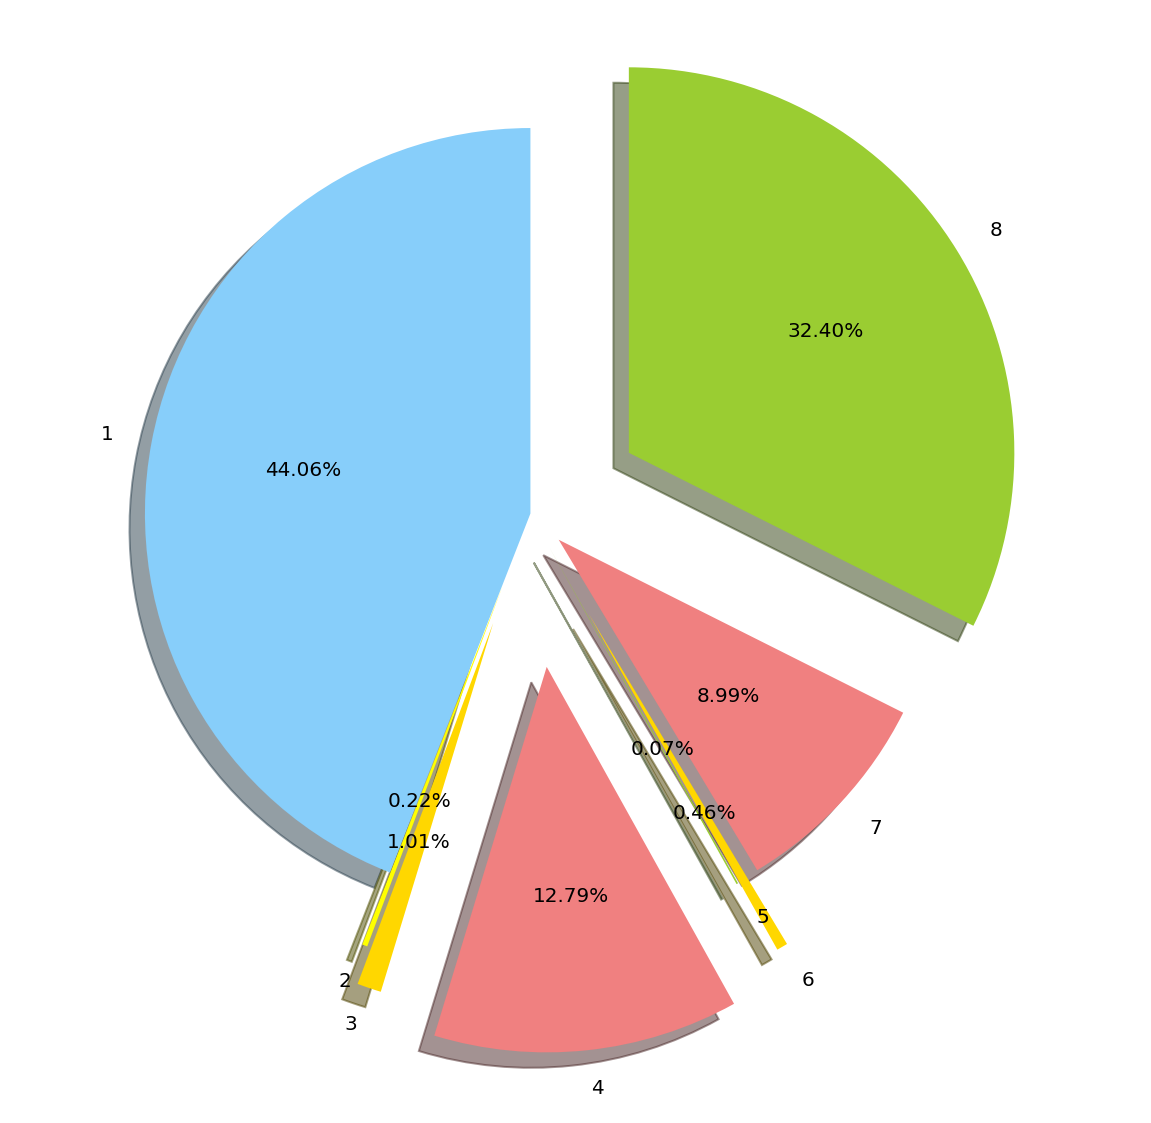

In [15]:
# labels = ['1','2','3','4','5']
labels = ['1','2','3','4','5','6','7','8']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen', 'gold', 'lightcoral', 'yellowgreen']
explode = (0, 0.2, 0.3, 0.4, 0.1,0.3, 0.1,0.3)
plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [16]:
cluster_df = pd.DataFrame(clusters)
cluster_df.index = portrait_df.index
normalized_df = pd.DataFrame(X)
normalized_df.index = portrait_df.index
frame = pd.concat([portrait_df, normalized_df, cluster_df], axis=1)

In [17]:
frame.columns = ['frequency', 'recency', 'monetary_value', 'norm_frequency', 'norm_recency', 'norm_monetary_value', 'group']
frame.to_csv('VijayDataResult.csv')

* Simply to check the difference between various clusters

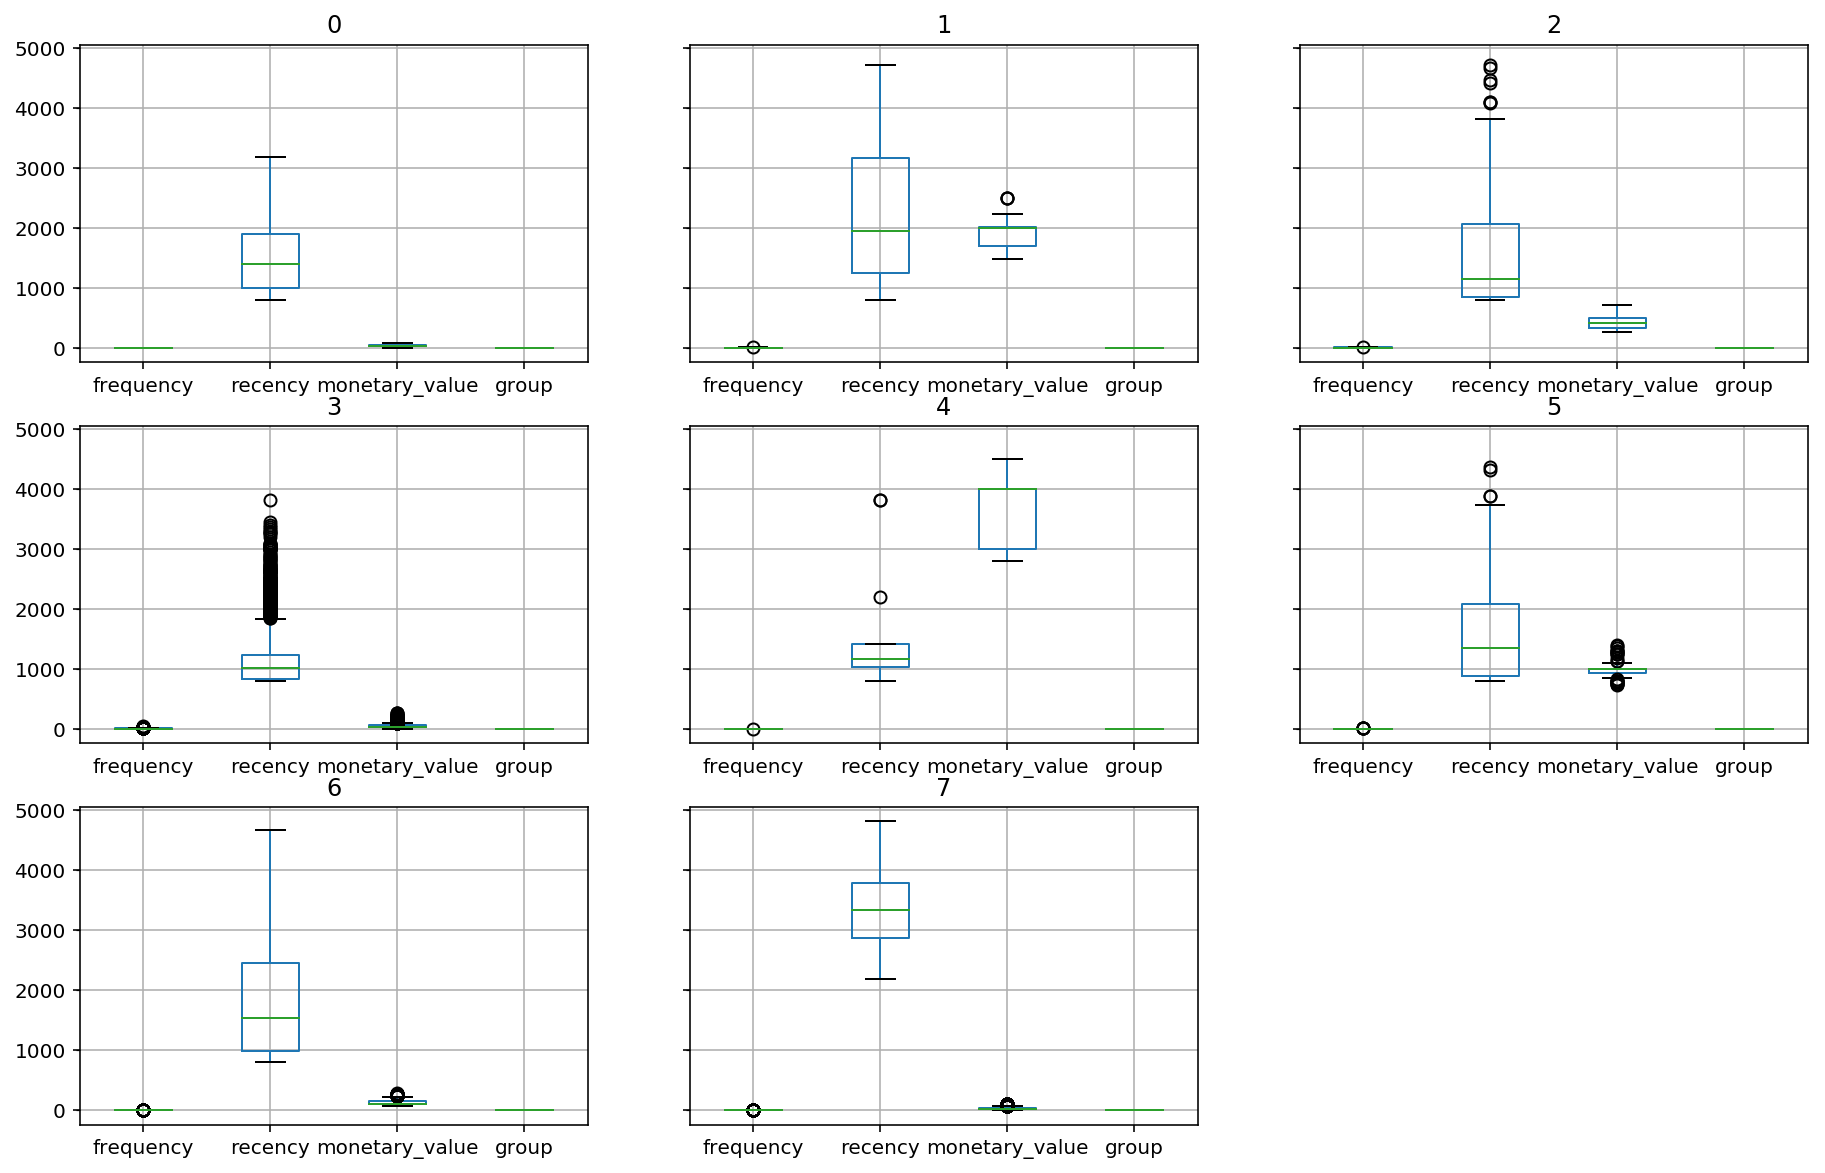

In [18]:
frame[['frequency', 'recency', 'monetary_value','group']].groupby('group').boxplot()
# rfm_amalysis_df[['frequency', 'recency', 'monetary_value']]
plt.gcf().set_size_inches(15, 10)
plt.show()

In [19]:
frame.head()

,frequency,recency,monetary_value,norm_frequency,norm_recency,norm_monetary_value,group
UserID,,,,,,,
10,1.0,4603,30.000000,0.000020,0.000121,0.000028,7
80,7.0,1147,71.428571,0.000137,0.000030,0.000067,3
90,10.0,1798,115.800000,0.000195,0.000047,0.000109,3
120,1.0,2263,20.000000,0.000020,0.000059,0.000019,7
130,2.0,3774,50.000000,0.000039,0.000099,0.000047,7


### budget analysis

* These values below will be set in UI/UX as user input

In [20]:
# total budget for this campaign
budget = 800000
# type of this reward, currently set as cash voucher for illustration, later will also set to cash back %
type_reward = 'cash voucher'
# minimum type of reward
min_reward_amount = 5
# minimum expiration == no expiration
min_reward_exp = 'no expiration'
# switch -- whether all of the consumers have reward
all_distribute = 1

* Summarize the RFM stats for each cluster considered

In [21]:
rfm_amalysis_df = frame.groupby('group').agg({'frequency': lambda x: x.mean(), # Recency
                                              'recency': lambda x: x.mean(),      # Frequency
                                              'monetary_value': lambda x: x.mean()}) # Monetary Value"
rfm_amalysis_df['num_in_group'] = frame.groupby('group').frequency.count()
rfm_amalysis_df['spent'] = frame.groupby('group').monetary_value.sum()
rfm_amalysis_df.sort_values('monetary_value')

,frequency,recency,monetary_value,num_in_group,spent
group,,,,,
7,1.398961,3338.883210,29.307203,5968,174905.390000
0,2.081701,1459.103266,34.613430,8115,280887.982833
3,8.971550,1188.173248,49.212369,2355,115895.128554
6,2.264653,1825.922054,123.530417,1655,204442.840159
2,4.172043,1581.172043,429.417603,186,79871.674230
5,2.800000,1652.941176,1003.732335,85,85317.248463
1,2.025000,2231.750000,1905.234810,40,76209.392381
4,2.307692,1607.769231,3603.365385,13,46843.750000


E.g., all of our customers get reward distributed.

In [23]:
rfm_sort_mv_df = rfm_amalysis_df.sort_values('monetary_value').reset_index()

if all_distribute == 1:
    low_mv_df = rfm_sort_mv_df[rfm_sort_mv_df.monetary_value<frame.monetary_value.mean()]
    high_mv_df = rfm_sort_mv_df[rfm_sort_mv_df.monetary_value>=frame.monetary_value.mean()]
    rest_reward = budget - min_reward_amount * low_mv_df.num_in_group.sum()
    
    ##########################################
    # for those who are below average comsumption
    low_mv_reward = str(1) + ' piece of ' + str(min_reward_amount) + ' dollar ' + type_reward + ', ' + min_reward_exp
    low_mv_df['reward'] = low_mv_reward
    
    ##########################################
    # for those who are above
    high_mv_df['total_reward'] = high_mv_df.monetary_value / high_mv_df.monetary_value.sum() * rest_reward
    high_mv_df['indiv_reward'] = high_mv_df.total_reward / high_mv_df.num_in_group

    high_mv_df['recency'] = high_mv_df.recency - high_mv_df.recency.min()
    high_mv_df = high_mv_df.sort_values('recency')
    high_mv_df['recency'] = high_mv_df.recency / 7 # week

    tickets = 2 / high_mv_df.frequency * high_mv_df.frequency.max() 
    high_mv_df['tickets'] = tickets.map(np.round)


/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

* A simple algo that returns the number of bits for the figure

In [24]:
def return_bits(input):
    i=0
    input = int(input)
    while 1:
        if input/10 == 0:
            return i
        else:
            input = input / 10
            i = i+1

#### According to the consumption behaviour, ppl are segmented to low groups and high groups, where different rewards will be given

In [25]:
low_mv_df

,group,frequency,recency,monetary_value,num_in_group,spent,reward
0,7,1.398961,3338.883210,29.307203,5968,174905.390000,"1 piece of 5 dollar cash voucher, no expiration"
1,0,2.081701,1459.103266,34.613430,8115,280887.982833,"1 piece of 5 dollar cash voucher, no expiration"
2,3,8.971550,1188.173248,49.212369,2355,115895.128554,"1 piece of 5 dollar cash voucher, no expiration"


* According to frequency and recency, we have the following distribution, where
    * frequency controls the number of the vouchers (we encourage lesser frequent consumers)
    * recency controls the expiration of the vouchers (we encourage those 'long time no see' a quick back)
* Monetary value is adapting with return_bits() for rounding issue

In [26]:
reward_for_high = []
for i in range(high_mv_df.shape[0]):
    sub_money = high_mv_df.iloc[i].indiv_reward / high_mv_df.iloc[i].tickets
    reward_for_high.append(str(int(high_mv_df.iloc[i].tickets)) + ' pieces of ' + \
    str(np.round(sub_money, decimals = -return_bits(sub_money))) +\
    ' dollar ' + type_reward + ', ' + str((high_mv_df.shape[0] - i)) + ' weeks of expiration') 
    
high_mv_df['reward'] = pd.Series(data=reward_for_high, index=high_mv_df.group.index)
high_mv_df = high_mv_df[['frequency', 'recency', 'monetary_value','group','num_in_group', 'spent', 'reward']]
high_mv_df

,frequency,recency,monetary_value,group,num_in_group,spent,reward
4,4.172043,0.000000,429.417603,2,186,79871.674230,"2 pieces of 100.0 dollar cash voucher, 5 weeks..."
7,2.307692,3.799598,3603.365385,4,13,46843.750000,"4 pieces of 7000.0 dollar cash voucher, 4 week..."
5,2.800000,10.252733,1003.732335,5,85,85317.248463,"3 pieces of 400.0 dollar cash voucher, 3 weeks..."
3,2.264653,34.964287,123.530417,6,1655,204442.840159,"4 pieces of 2.0 dollar cash voucher, 2 weeks o..."
6,2.025000,92.939708,1905.234810,1,40,76209.392381,"4 pieces of 1000.0 dollar cash voucher, 1 week..."


In [27]:
result_df = pd.concat([low_mv_df,high_mv_df]).sort_values('group')
result_df

,frequency,group,monetary_value,num_in_group,recency,reward,spent
1,2.081701,0,34.613430,8115,1459.103266,"1 piece of 5 dollar cash voucher, no expiration",280887.982833
6,2.025000,1,1905.234810,40,92.939708,"4 pieces of 1000.0 dollar cash voucher, 1 week...",76209.392381
4,4.172043,2,429.417603,186,0.000000,"2 pieces of 100.0 dollar cash voucher, 5 weeks...",79871.674230
2,8.971550,3,49.212369,2355,1188.173248,"1 piece of 5 dollar cash voucher, no expiration",115895.128554
7,2.307692,4,3603.365385,13,3.799598,"4 pieces of 7000.0 dollar cash voucher, 4 week...",46843.750000
5,2.800000,5,1003.732335,85,10.252733,"3 pieces of 400.0 dollar cash voucher, 3 weeks...",85317.248463
3,2.264653,6,123.530417,1655,34.964287,"4 pieces of 2.0 dollar cash voucher, 2 weeks o...",204442.840159
0,1.398961,7,29.307203,5968,3338.883210,"1 piece of 5 dollar cash voucher, no expiration",174905.390000


* The full reward messages for the data frame above

In [28]:
for each in result_df.reward:
    print each

1 piece of 5 dollar cash voucher, no expiration
4 pieces of 1000.0 dollar cash voucher, 1 weeks of expiration
2 pieces of 100.0 dollar cash voucher, 5 weeks of expiration
1 piece of 5 dollar cash voucher, no expiration
4 pieces of 7000.0 dollar cash voucher, 4 weeks of expiration
3 pieces of 400.0 dollar cash voucher, 3 weeks of expiration
4 pieces of 2.0 dollar cash voucher, 2 weeks of expiration
1 piece of 5 dollar cash voucher, no expiration


* Save the file

In [29]:
result_df.to_csv('reward_distributed.csv', index=False)

* Done

In [100]:
# rfm_max_df = frame.groupby('group').agg({'frequency': lambda x: x.max(), 'recency': lambda x: x.max(), 'monetary_value': lambda x: x.max()}) 
# rfm_min_df = frame.groupby('group').agg({'frequency': lambda x: x.min(), 'recency': lambda x: x.min(), 'monetary_value': lambda x: x.min()}) 
# pd.concat([rfm_amalysis_df, rfm_min_df,rfm_max_df],axis=1)

In [98]:
# sub_frame = frame[['frequency', 'recency', 'monetary_value']]
# sub_frame['recency'] = frame.recency - frame.recency.min()
# from sklearn.preprocessing import normalize
# # some = np.array([])
# normed_some = normalize(sub_frame, axis=0, norm='l1')
# pd.DataFrame(normed_some).head()

# K=8
# kmeanModelfinal = KMeans(n_clusters=K, algorithm='elkan').fit(normed_some)
# from collections import Counter
# clusters = kmeanModelfinal.labels_.tolist()
# clusters_dic = Counter(clusters)
# pie_vec = [clusters_dic[i] for i in range(K)]
# print pie_vec

# labels = ['1','2','3','4','5','6','7','8']
# colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen', 'gold', 'lightcoral', 'yellowgreen']
# explode = (0, 0.2, 0.3, 0.4, 0.1,0.3, 0.1,0.3)
# plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
# plt.gcf().set_size_inches(10, 10)

# # Set aspect ratio to be equal so that pie is drawn as a circle.
# plt.axis('equal')
# plt.show()

In [60]:
# sub_df={}
# for i in range(frame.group.max()+1):
#     sub_df[i] = frame[frame.group == i]

### Hierarchical Clustering

In [47]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

In [66]:
# # Just to show case that the whole data is tree-like 
# plt.figure(figsize=(25, 10))
# plt.scatter(X_ori[:, 0], X_ori[:, 2])
# plt.show()

* Simply, if the cophenet value is closer to 1, the more information of distance is reserved.

In [67]:
# Perform Hierarchical Clustering
Z = linkage(X, 'ward')

from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
print c

0.652516769958


* Way of plot Dendrogram

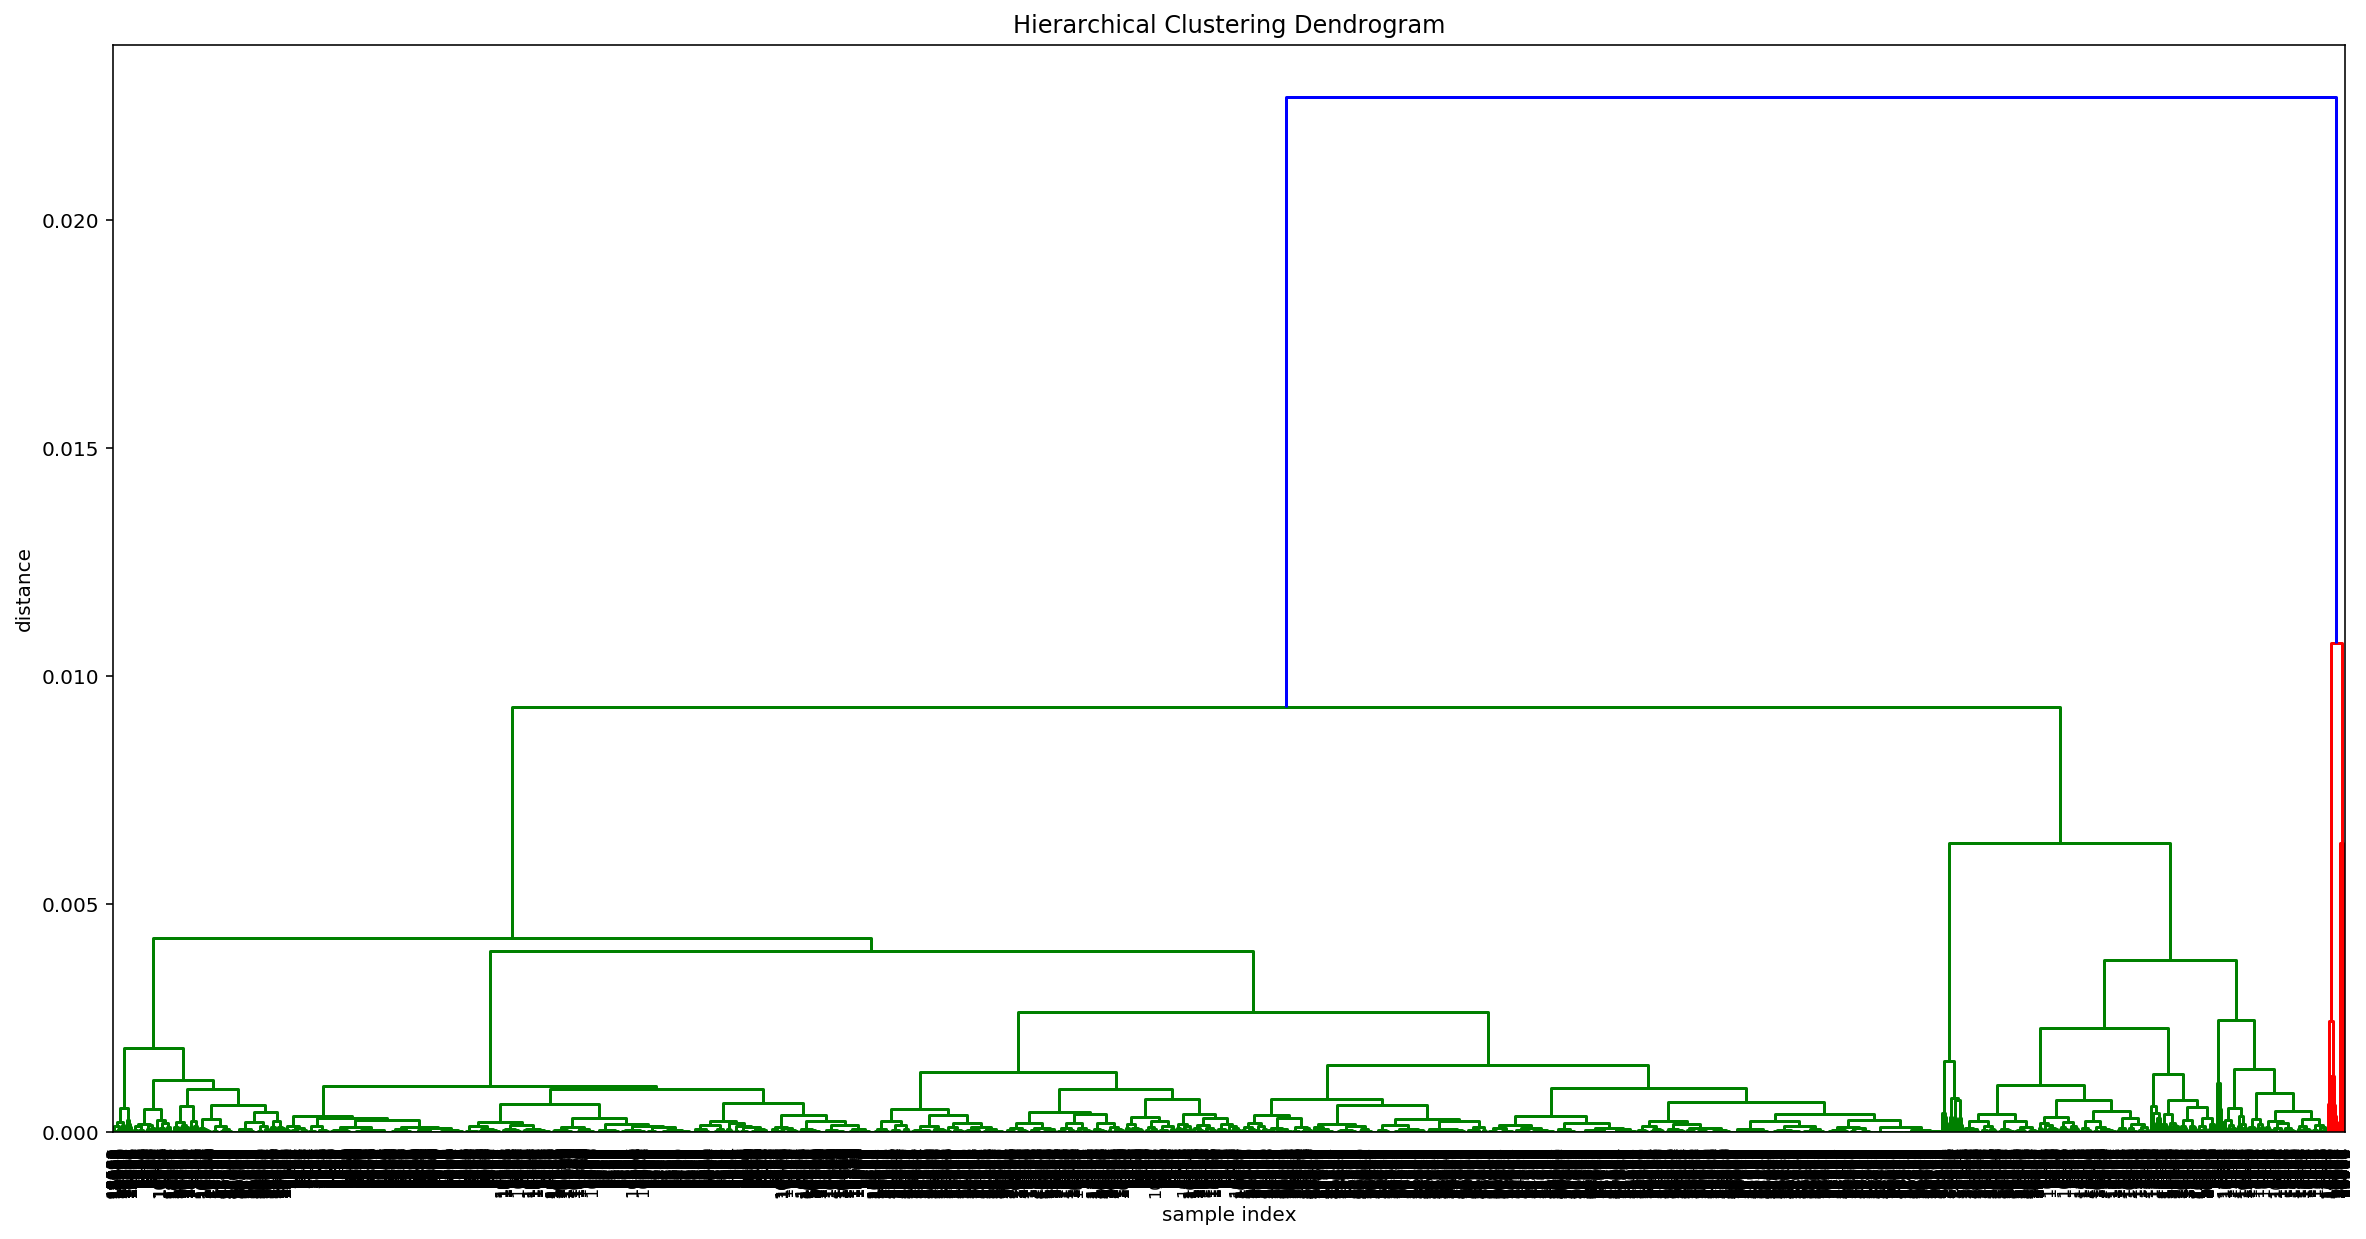

In [76]:
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

* As the dendrogram above make little sense, the truncated dendrogram below hence aids our understanding as each leaf node is already a kind of clustering result.
* Hereafter, we can have a cut on distance to acquire our desired clusters.
* For the clusters analysis, still follow the procedure above.

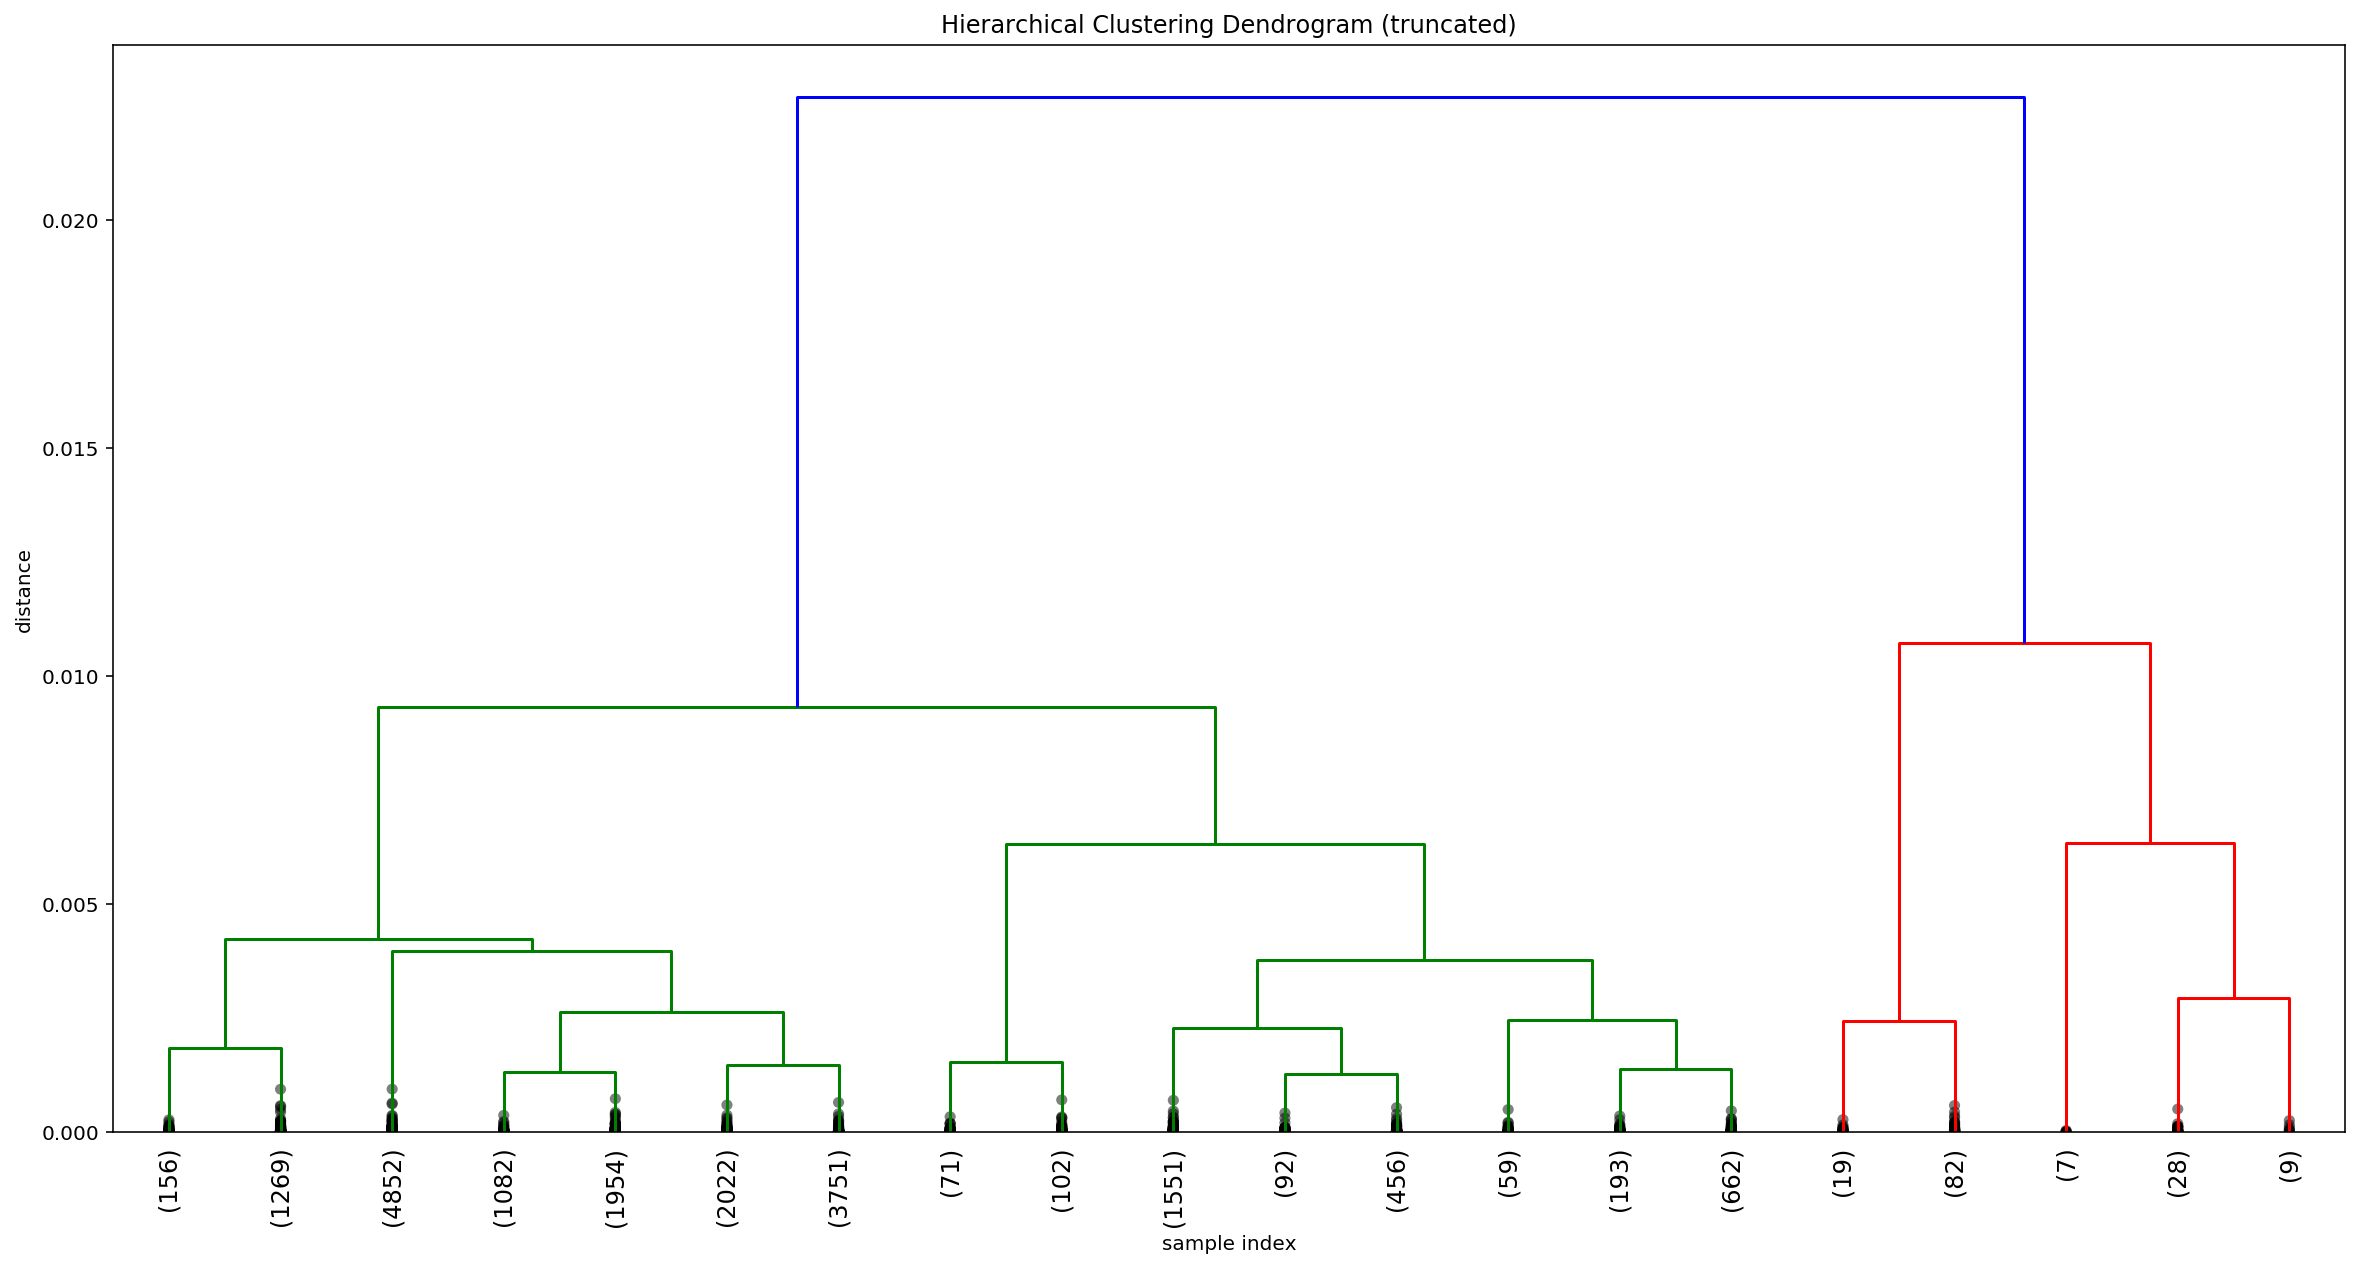

In [77]:
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, truncate_mode='lastp', p=20, show_leaf_counts=True, 
           leaf_rotation=90., leaf_font_size=12., show_contracted=True)

plt.show()

### Cover Tree for Clustering (faster way)

In [31]:
# %%bash
# pwd

In [32]:
import scipy
from CoverTree.covertree import *

In [33]:
def breadth_travel(root):
    if root == None:
        return
    collector = []
    queue = []
    queue.append(root)
    while queue:
        node = queue.pop(0)
        for i in range(len(node.children)):
            try:
                node.children[i].level
                queue.append(node.children[i])
            except:
                collector.append(node.children[i].idx)
    return collector

cluster_bags = list()
def ct_query_cluster(node, base_level = 1):
    for i in range(len(node.children)):
        try:
            node.children[i].level
            if node.level > base_level:
                ct_query_cluster(node.children[i], base_level)
            elif node.level <= base_level:
                cluster_bags.append(breadth_travel(node.children[i]))
        # if node.children[i].level is failing in running，was because it is a _LeafNode such that a return is needed
        except:
            cluster_bags.append(node.children[i].idx) 
            continue


In [35]:
ct = CoverTree(X,scipy.spatial.distance.euclidean, leafsize=50, base=2)
ct._print()

 <_InnerNode: ctr_idx=15988, level=-7 (radius=0.015625), len(children)=2, num_children=18417>
- <_InnerNode: ctr_idx=15988, level=-9 (radius=0.003906), len(children)=2, num_children=18415>
-- <_InnerNode: ctr_idx=15988, level=-10 (radius=0.001953), len(children)=3, num_children=18370>
--- <_InnerNode: ctr_idx=15988, level=-11 (radius=0.000977), len(children)=3, num_children=18299>
---- <_InnerNode: ctr_idx=15988, level=-12 (radius=0.000488), len(children)=3, num_children=18172>
----- <_InnerNode: ctr_idx=15988, level=-13 (radius=0.000244), len(children)=6, num_children=17564>
------ <_InnerNode: ctr_idx=15988, level=-14 (radius=0.000122), len(children)=12, num_children=15574>
------- <_InnerNode: ctr_idx=15988, level=-15 (radius=0.000061), len(children)=12, num_children=2990>
-------- <_InnerNode: ctr_idx=15988, level=-16 (radius=0.000031), len(children)=4, num_children=415>
--------- <_InnerNode: ctr_idx=15988, level=-17 (radius=0.000015), len(children)=6, num_children=164>
----------

-------- _LeafNode(idx=[6528, 10534, 12562, 13745, 13362, 6078, 11503, 12310, 12435, 13526, 4973, 12403, 12078, 13899, 12499, 12954, 14347, 12358, 13970, 14076, 12571, 10867, 13854, 6162, 12531, 9783, 11972, 12347, 6588, 12014, 12070, 12221, 13633, 13805, 12002], ctr_idx=10534, radius=0.000012)
-------- _LeafNode(idx=[305, 1931, 2247, 4901, 973, 1149, 46, 95, 109, 331, 540, 560, 571, 625, 721, 972, 1027, 1084, 1125, 1569, 1620, 1938, 2176, 2304, 2348, 2493, 2618, 2954, 3422, 3694, 556, 742, 1329, 1803, 3006, 3901, 2824, 3884, 2748, 2933, 3195, 5875, 6593, 817, 962, 1085], ctr_idx=305, radius=0.000030)
------- <_InnerNode: ctr_idx=12168, level=-16 (radius=0.000031), len(children)=2, num_children=94>
-------- <_InnerNode: ctr_idx=12168, level=-17 (radius=0.000015), len(children)=4, num_children=92>
--------- _LeafNode(idx=[11126, 12246, 12367, 12597, 13216, 13927, 1347, 4121, 12168, 12884, 2021, 16033, 6442, 11956, 12356, 13454, 13690, 14033, 16070, 12215, 15612, 689, 12419, 2146, 2619, 

* This is to perform clustering using the function I made (currently test okay)
* This is more like Vijay's idea of hierarchical clustering
* Function accepts root node and level of the desired layer

In [43]:
ct_query_cluster(ct.root,-9)

In [44]:
len(cluster_bags)

10

In [117]:
# summm = 0
# for each in cluster_dist:
#     print len(each)
#     summm = summm + len(each)
# print summm

In [45]:
cluster_bags

[[[668,
   1014,
   1505,
   1561,
   1674,
   3911,
   4122,
   6126,
   6140,
   6324,
   7129,
   7418,
   8258,
   8366,
   8469,
   9504,
   10005,
   10143,
   10748,
   11197,
   12689,
   12697,
   13657,
   15322,
   16028,
   17334,
   18103,
   4772,
   4773,
   4774,
   6020,
   9621,
   10498,
   11383,
   15325,
   15512,
   15537,
   16904,
   17095,
   734,
   6041,
   8412,
   13154,
   15591,
   17165],
  [457, 6978],
  [746, 772, 662, 8302, 268, 2427, 49, 260, 526, 534, 4572, 7601, 7868],
  [10843,
   13977,
   618,
   7271,
   7811,
   8435,
   8929,
   9684,
   10512,
   10732,
   12219,
   12321,
   13389,
   13439,
   14258,
   15280,
   15375,
   15419,
   15523,
   15980,
   16036,
   16081,
   17047,
   17078,
   17083,
   17108,
   17135,
   17281,
   17332,
   17971,
   17980,
   18153,
   18282,
   18291,
   18293,
   18402,
   1731,
   4425,
   13505,
   1372,
   1717,
   4334,
   6019,
   10708,
   12708,
   16058],
  [6986,
   9551,
   16894,
   1728,
  

In [116]:
cluster_dist = []
for each_bag in cluster_bags:   
    try:
        temp = []
        for each in each_bag:
            temp = temp + each
        cluster_dist.append(temp)
    except:
        cluster_dist.append(each_bag)

# Temporarily finished here, below are constructing still

# Temporarily finished here, below are constructing still

# Temporarily finished here, below are constructing still

### #####

In [ ]:
def reward_distribution(df, reward_amount, reward_level):
    assert df.group
    

Change the column name for the clustering result.

In [ ]:
frame_column_name = list(frame.columns)
frame_column_name[-1]='cluster'
frame.columns = frame_column_name

In [ ]:
frame = frame.reset_index()
frame.head(2)

In [ ]:
def days_to_year(input):
    try:
        return (NOW - input).days/365
    except:
        return 0
customer['BDay'] = pd.to_datetime(customer['DateofBirth']).dt.date
customer['Age'] = customer.BDay.map(days_to_year)

In [ ]:
customer.head(2)

In [ ]:
Tops_customer = customer[customer.CustomerID.isin(frame.CustomerID)][['CustomerID', "Nationality","Gender","MaritalStatus",'HaveOnlineaccount','Age']]
sorted_Tops_customer = Tops_customer.sort_values('CustomerID')

To better incorporate information, the customer csv file is hence combined with some useful fields.

In [ ]:
# sorted_Tops_customer['CustomerIDR'] = sorted_Tops_customer.CustomerID
# sorted_Tops_customer.head(2)
big_frame = pd.merge(frame, sorted_Tops_customer, how='inner')
# ,left_on=frame.CustomerID, right_on=sorted_Tops_customer.CustomerIDR)

In [ ]:
big_frame.head(2)

### Group Labelling

With the customer clustered, a simple analysis can be hence carried out for an "automated" labelling of the corresponding group/cluster to better understand them. For a better illustration, I have turned different fields to similar [0, 1] scale where all the info can be gathered in one plot.

In [ ]:
import math

def autolabel(rects): 
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/5., 0.025 + height, "%.2f" % float(height))
        
def autolabel_realvalue(rects, realvalues): 
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        plt.text(rect.get_x(), 0.01 + height, "%.4s" % float(realvalues[idx])) #+rect.get_width()/5.
        
def return_log_list(list):
    return [math.log(list[i]) if list[i]>1 else 0 for i in range(len(list)) ]

def normalize_vec(vec):
    v_min, v_max = vec.min(), vec.max() 
    return (vec-v_min)/(v_max-v_min)  

def portionwise(vec):
    return vec / sum(vec)
#     return vec * 1.0 / sum(vec)

In [ ]:
cluster_name_list = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
# x =list(range(5)) 
x = np.arange(K)
total_width, n = 0.8, 8 
width = total_width / n  
x = x - (total_width - width) / 2

rects = plt.bar(x,portionwise(list(frame.groupby('cluster').refund.mean())),
                tick_label = cluster_name_list, color = 'gold', width=width, label = 'mean-refund',)
plt.title("Cluster Analysis for each group")

autolabel_realvalue(rects, frame.groupby('cluster').refund.mean())
# autolabel(rects)

rects_2 = plt.bar(x + width, portionwise(list(frame.groupby('cluster').total_spent.mean())),
                  tick_label = cluster_name_list, color = 'lightskyblue', width=width, label='mean-spent') 
# rects_2 = plt.bar(x, return_log_list(frame.groupby('cluster').total_spent.mean()),
#                   tick_label = cluster_name_list, color = 'lightskyblue', width=width, label='mean-spent') 
# autolabel(rects_2)

# for i in range(len(x)):  
#     x[i] = x[i] + width  
rects_2 = plt.bar(x + 2 * width, portionwise(list(frame.groupby('cluster').refund.sum())),
                  tick_label = cluster_name_list, color = 'yellowgreen', width=width, label='total-refund') 
# autolabel(rects_2)
autolabel_realvalue(rects_2, frame.groupby('cluster').refund.sum())

# for i in range(len(x)):  
#     x[i] = x[i] + width  
# rects_3 = plt.bar(x, return_log_list(frame.groupby('cluster').refund.count()),
#                   tick_label = cluster_name_list, color = 'lightcoral', width=width, label='#customer') 
rects_3 = plt.bar(x + 3 * width, portionwise(list(frame.groupby('cluster').frequency.mean())),
                  tick_label = cluster_name_list, color = 'lightcoral', width=width, label='mean-freq') 
# autolabel(rects_3)


# for i in range(len(x)):  
#     x[i] = x[i] + width
localization = list(big_frame.groupby('cluster').Nationality.agg({lambda x: list(x=='Thai').count(True) * 1.0 / len(x)})['<lambda>'])
rects_4 = plt.bar(x + 4 * width, portionwise(localization),
                  color = 'g', width=width, label='localization') 


male = list(big_frame.groupby('cluster').Gender.agg({lambda x: list(x=='M').count(True) * 1.0 / len(x)})['<lambda>'])
female = list(big_frame.groupby('cluster').Gender.agg({lambda x: list(x=='F').count(True) * 1.0 / len(x)})['<lambda>'])

available_gender = np.array(male) + np.array(female)
male_portion = np.array(male) / available_gender
female_portion = np.array(female) / available_gender
total_bar = portionwise(available_gender)
male_section = total_bar * male_portion
female_section = total_bar * female_portion

rects_5 = plt.bar(x + 5 * width, female_section, 
                  color = 'r', width=width, label='female') 
rects_6 = plt.bar(x + 5 * width, male_section,
                  bottom=female_section, color = 'b', width=width, label='male') 

# for i in range(len(x)):  
#     x[i] = x[i] + width
rects_7 = plt.bar(x + 6 * width, portionwise(big_frame.groupby('cluster').Age.std()),
                  color = 'grey', width=width, label='std-age') 


plt.xlabel("Group Indicator")
plt.ylabel("Portionwise level for the fields considered")

plt.legend()
plt.gcf().set_size_inches(16, 10)
plt.show()

### Figure above shows the cluster analysis -- the number above indicating the real value, while all of them are compressed into same scale (portionwise) for visualization only.

In [ ]:
labels = ['least frequent comers',
          '7 Local high-spent customers with most refund record',
          'normal behavior -- should have more vouchers to encourage them',
          'most averaged group, nothing special',
          'nice group in terms of both frequently and spent, while no refunding']
colors = ['lightskyblue', 'green', 'gold', 'lightcoral', 'yellowgreen']

colors[1], colors[0] = colors[0], colors[1]
pie_vec[1], pie_vec[0] = pie_vec[0], pie_vec[1]
labels[1], labels[0] = labels[0], labels[1]

explode = (0, 0.2, 0.3, 0.4, 0.1)
plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)
print pie_vec
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

## Correlation Analysis
### The 'frequency', 'valid transaction' and 'varieties' are highly correlated -- means that: come more, shop more and pick more

In [ ]:
# print normalize_vec(np.array(frame.groupby('cluster').valid_trans.mean()))
    
aa = list(frame.groupby('cluster').frequency.mean())
bb = list(frame.groupby('cluster').valid_trans.mean())
cc = list(frame.groupby('cluster').varieties.mean())
print np.corrcoef(aa,bb)[0,1]
print np.corrcoef(bb,cc)[0,1]
print np.corrcoef(aa,cc)[0,1]

In [ ]:
# print normalize_vec(np.array(frame.groupby('cluster').valid_trans.mean()))
    
aa = list(frame.groupby('cluster').total_spent.mean())
bb = list(frame.groupby('cluster').avg_spent.mean())
cc = list(frame.groupby('cluster').med_spent.mean())
print np.corrcoef(aa,bb)[0,1]
print np.corrcoef(bb,cc)[0,1]
print np.corrcoef(aa,cc)[0,1]

In [ ]:
frame.groupby('cluster').total_spent.mean()

In [ ]:
frame.groupby('cluster').refund.mean()

In [ ]:
# for item in frame.groupby('cluster').refund.sum():
    

type(frame.groupby('cluster').refund.sum()[0])

In [ ]:
math.log(1.21)
# frame.groupby('cluster').refund.sum()

### Observation: Current result is with some coarse characteristics for each run-out cluster, however, since the data is biased (as is already a class of customers), current observation is limited. In the near future, we will add hierarchical clustering on top to better define the behavior of customers. 

In [ ]:
kmeanModelfinal_8 = KMeans(n_clusters=8, algorithm='elkan').fit(X)

clusters_8 = kmeanModelfinal_8.labels_.tolist()
clusters_dic_8 = Counter(clusters_8)
pie_vec_8 = [clusters_dic_8[i] for i in range(8)]
print pie_vec_8

labels = ['1','2','3','4','5','6','7','8']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen','red','orange','green','blue','black']
# explode = (0, 0.2, 0.3, 0.4, 0.1)
# explode=explode, 
plt.pie(pie_vec_8, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [ ]:
kmeanModelfinal_10 = KMeans(n_clusters=10, algorithm='elkan').fit(X)

clusters_10 = kmeanModelfinal_10.labels_.tolist()
clusters_dic_10 = Counter(clusters_10)
pie_vec_10 = [clusters_dic_10[i] for i in range(10)]
print pie_vec_10

labels = ['1','2','3','4','5','6','7','8','9','10']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen','red','orange','green','blue','black']
# explode = (0, 0.2, 0.3, 0.4, 0.1)
# explode=explode, 
plt.pie(pie_vec_10, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [ ]:
[3128, 100, 2, 20, 30, 664, 3, 1, 1, 1049]

## Appendix 

### Data issue to be fixed on

In [ ]:
big_frame.groupby('cluster').Age.min()

Check when the customer IDs are matched -- 
previously solving the case that "big_frame = pd.merge(frame, sorted_Tops_customer, how='inner',                     left_on=frame.index, right_on=sorted_Tops_customer.CustomerID)" is not working.

In [ ]:
def examine_str_match(input1, input2):
    if input1 == input2:
        return 0
    else:
        return 1
    
if sum([examine_str_match(each, sorted_Tops_customer.iloc[idx].CustomerID) for idx, each in enumerate(frame.index)]) == 0:
    print 'test passed'


Plot two stuff on the same page.

In [ ]:
import matplotlib.pyplot as plt

x = range(10)
y1 = [elem*2 for elem in x]
plt.plot(x, y1)

y2 = [elem**2 for elem in x]
plt.plot(x, y2, 'r--')

plt.show()

Just to prove that Agglomerative Clustering is not working on this data set.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

In [ ]:
# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)
sum(sum(knn_graph.nonzero()))*1.0/1500/1500

An example to visualize “Agglomerative clustering with and without structure”

In [ ]:
for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

### For James' enquery on nationalities

In [ ]:
len(big_frame[big_frame.Nationality == 'Russian'])

In [ ]:
len(big_frame[big_frame.Nationality == 'Thai'])

In [ ]:
len(Counter(big_frame.Nationality))

In [ ]:
Counter(big_frame.Nationality)

In [ ]:
print frame.groupby('cluster').total_spent.mean()
print (frame.groupby('cluster').total_spent.std())

frame.groupby('cluster').refund.sum()
return_log_list(frame.groupby('cluster').total_spent.std())


#### Scatter Plot

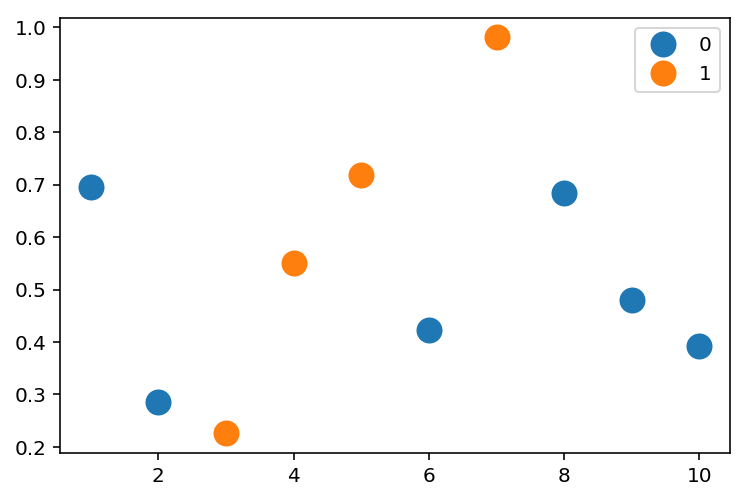

In [288]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(123)

# Generate Data
nbr_dim = 10
y = np.random.random((nbr_dim))
x = [1,2,3,4,5,6,7,8,9,10]
labels = np.random.choice([0, 1], nbr_dim)
df = pd.DataFrame(dict(x=x, y=y, label=labels))

groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

## Creating the fields as the user portrait -- comprehensive feature engineering

In [ ]:
Tops_trans_df['tDate2'] = pd.to_datetime(Tops_trans_df['TransactionDate']).dt.date
recency = grouped_by_userID.tDate2.agg({'recency': lambda x: (NOW - x.max()).days})

In [ ]:
spent = grouped_by_userID.Spending.agg({'total_spent': np.sum, 'avg_spent': np.mean, 'med_spent': np.median})

In [ ]:
spent_range = grouped_by_userID.Spending.agg({'spent_range': lambda x: x.max()- x.min()})

In [ ]:
frequency = grouped_by_userID.TicketNumber.agg({'frequency': lambda x: len(x)})

In [ ]:
quantities = grouped_by_userID.QTY.agg({'quantities': np.sum})

In [ ]:
from collections import Counter 
varieties = grouped_by_userID.SKUCode.agg({'varieties': lambda x: len(Counter(x))})

In [ ]:
valid = grouped_by_userID.Spending.agg({'valid_trans': np.count_nonzero})
refund = grouped_by_userID.Spending.agg({'refund': lambda x: len(x[x<0])})
# Counter(Tops_trans_df.Spending<0)[True]

In [ ]:
portrait_df = pd.concat([recency, spent, spent_range, quantities, varieties, frequency, valid, refund],join="inner",axis=1)
portrait_df.head(3)